In [1]:
import os
import sys

curdir = '/home/frederik/Dropbox/GitHub/Magritte/tests/'
datdir = f'{curdir}/data/'
moddir = f'{curdir}/models/'
resdir = f'{curdir}/results/'

import numpy             as np
import scipy             as sp
import healpy            as hp
import matplotlib.pyplot as plt
import magritte.tools    as tools
import magritte.setup    as setup
import magritte.mesher   as mesher
import magritte.core     as magritte

from scipy.interpolate import interp1d


dimension = 3
nrays     = 12*3**2
nspecs    = 5
nlspecs   = 1
nquads    = 2

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
temp   = 20.0     # [K]
turb   = 150.00   # [.]

get_X_mol = {
    'a' : 1.0E-8,
    'b' : 1.0E-6
}

scale_max = 0.09 * r_out
scale_min = 0.09 * r_in
scale_cte = 0.09 * r_in
scale_fun = f'{scale_cte / r_in**2} * (x*x + y*y + z*z)'

meshName = f'{moddir}/vanZadelhoff_1_3D_mesher.vtk'

mesher.create_mesh_from_function(
    meshName       = meshName,
    boundary       = mesher.boundary_sphere_in_sphere(
                         radius_in  = r_in,
                         radius_out = r_out),
    scale_min      = scale_min,
    scale_max      = scale_max,
    scale_function = scale_fun )

Info    : Running 'gmsh /home/frederik/Dropbox/GitHub/Magritte/tests//models//vanZadelhoff_1_3D_mesher.geo -3 -saveall -o /home/frederik/Dropbox/GitHub/Magritte/tests//models//vanZadelhoff_1_3D_mesher.vtk' [Gmsh 4.4.1, 1 node, max. 1 thread]
Info    : Started on Fri Jan 29 08:16:55 2021
Info    : Reading '/home/frederik/Dropbox/GitHub/Magritte/tests//models//vanZadelhoff_1_3D_mesher.geo'...
Info    : Done reading '/home/frederik/Dropbox/GitHub/Magritte/tests//models//vanZadelhoff_1_3D_mesher.geo'
Info    : Meshing 1D...
Info    : Meshing curve 101 (Circle)
Info    : Meshing curve 102 (Circle)
Info    : Meshing curve 103 (Circle)
Info    : Meshing curve 104 (Circle)
Info    : Meshing curve 105 (Circle)
Info    : Meshing curve 106 (Circle)
Info    : Meshing curve 107 (Circle)
Info    : Meshing curve 108 (Circle)
Info    : Meshing curve 109 (Circle)
Info    : Meshing curve 110 (Circle)
Info    : Meshing curve 111 (Circle)
Info    : Meshing curve 112 (Circle)
Info    : Meshing curve 201 (C

In [2]:
mesh = mesher.Mesh(meshName)

npoints = len(mesh.points)
nbs     = [n for sublist in mesh.neighbors for n in sublist]
n_nbs   = [len(sublist) for sublist in mesh.neighbors]

rs = np.linalg.norm(mesh.points, axis=1)


a_or_b = 'a'

modelName = f'vanZadelhoff_1{a_or_b}_3D_mesher'
modelFile = f'{moddir}{modelName}.hdf5'
lamdaFile = f'{datdir}test.txt'

X_mol = get_X_mol[a_or_b]

def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

def nTT (r):
    return X_mol * nH2(r)

model = magritte.Model ()
model.parameters.set_spherical_symmetry(False)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set(mesh.points)
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model.parameters.set_nboundary(len(mesh.boundary))
model.geometry.boundary.boundary2point.set(mesh.boundary)

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()

model = magritte.Model (modelFile)
model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

0


/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


6


0

In [3]:
model.parameters.npoints()

24881

In [4]:
fcen = model.lines.lineProducingSpecies[0].linedata.frequency[0]
vpix = 100
dd = vpix * (model.parameters.nfreqs()-1)/2 / magritte.CC
fmin = fcen - fcen*dd
fmax = fcen + fcen*dd

model.compute_spectral_discretisation (fmin, fmax)
model.compute_image (model.parameters.hnrays()-1)

imx = np.array(model.images[-1].ImX)
imy = np.array(model.images[-1].ImY)
imI = np.array(model.images[-1].I)
imv = np.array(model.radiation.frequencies.nu)[0]

In [5]:
np.count_nonzero(np.isnan(imI)) // model.parameters.nfreqs()

0

In [6]:
rss = np.linalg.norm(model.geometry.points.position, axis=1)
abn = np.array(model.chemistry.species.abundance)[:,1]

In [7]:
import matplotlib.pyplot as plt

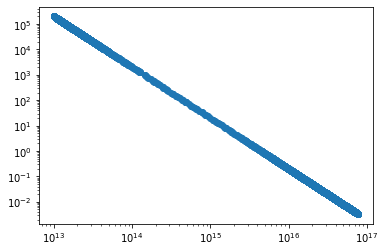

In [8]:
plt.scatter(rss, abn)
plt.xscale('log')
plt.yscale('log')

In [9]:
np.min(np.array(model.lines.emissivity))

1.1454452359569806899e-41

In [10]:
np.min(np.array(model.lines.opacity))

7.20481425990325241e-26

In [11]:
np.array(model.radiation.frequencies.nu)

array([[1.79875445e+11, 1.79875505e+11],
       [1.79875445e+11, 1.79875505e+11],
       [1.79875445e+11, 1.79875505e+11],
       ...,
       [1.79875445e+11, 1.79875505e+11],
       [1.79875445e+11, 1.79875505e+11],
       [1.79875445e+11, 1.79875505e+11]], dtype=float128)